In [ ]:
import tensorflow as tf

In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 5.3MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3023440 sha256=1dc7df5e1a19a755e40f63635b98a8ed8159f0b514f71c735b648ace5836bc9e
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
from vocab import MixVocab, Vocab
mixvocab = MixVocab.load('dataset/mix_vocab.json')
#vocab = Vocab.load('vocab.json')
#vocab.load_embeddings('vocab_embeddings.pkl')
mixvocab.load_embeddings('dataset/mix_vocab_embeddings.pkl')

In [ ]:
from sklearn.utils import shuffle
from dataset import Dataset
import numpy as np
def create_dataset(is_train):
        if is_train:
            dataset = Dataset.create_from_file('dataset/train.jsonl')
        else:
            dataset = Dataset.create_from_file('dataset/test.jsonl')
        old_code_data, new_code_data, comment_data, edit_data, Y = [], [], [], [], []
        for example in dataset.train_batch_iter(1, shuffle=False):

            old_code_tokens = mixvocab.token.words2indices(example.old_code_tokens)[0]
            new_code_tokens = mixvocab.token.words2indices(example.new_code_tokens)[0]
            edit_actions = mixvocab.action.words2indices(example.edit_actions)[0]
            src_tokens = mixvocab.token.words2indices(example.src_tokens)[0]
            tgt_tokens = mixvocab.token.words2indices(example.tgt_tokens)[0]

            old_code_data.append(old_code_tokens)
            new_code_data.append(new_code_tokens)
            comment_data.append(src_tokens)
            edit_data.append(edit_actions)
            Y.append(1)
            old_code_data.append(old_code_tokens)
            new_code_data.append(new_code_tokens)
            comment_data.append(tgt_tokens)
            edit_data.append(edit_actions)
            Y.append(0)
        return old_code_data, new_code_data, comment_data, edit_data, Y

In [ ]:
test_old_codeX, test_new_codeX, test_commentX, test_editX, testY = create_dataset(is_train=False)
old_codeX, new_codeX, commentX, editX, Y = create_dataset(is_train=True)

INFO:root:loading 9673 samples
INFO:root:loading 85657 samples


In [ ]:
old_codeX = np.array(old_codeX)
new_codeX = np.array(new_codeX)
commentX = np.array(commentX)
editX = np.array(editX)
Y = np.array(Y)
length = list(map(len, new_codeX))
q3 = np.quantile(length, 0.75)
filter_length = length <= q3
new_codeX = new_codeX[filter_length]
old_codeX = old_codeX[filter_length]
commentX = commentX[filter_length]
editX = editX[filter_length]
Y = Y[filter_length]
max_code_length = int(q3)

print(len(new_codeX))

128716


In [ ]:
test_new_codeX = np.array(test_new_codeX)
test_old_codeX = np.array(test_old_codeX)
test_commentX = np.array(test_commentX)
test_editX = np.array(test_editX)
testY = np.array(testY)
length = list(map(len, test_new_codeX))
q3 = np.quantile(length, 0.75)
filter_length = length <= q3
test_new_codeX = test_new_codeX[filter_length]
test_old_codeX = test_old_codeX[filter_length]
test_commentX = test_commentX[filter_length]
test_editX = test_editX[filter_length]
testY = testY[filter_length]
max_code_length = int(q3)

print(len(test_new_codeX))

14520


In [ ]:
max_comment_length = max(map(len, commentX))
print(max_code_length, max_comment_length)

188 52


In [ ]:
new_codeX = tf.keras.preprocessing.sequence.pad_sequences(
    new_codeX
)
test_new_codeX = tf.keras.preprocessing.sequence.pad_sequences(
    test_new_codeX
)

In [ ]:
old_codeX = tf.keras.preprocessing.sequence.pad_sequences(
    old_codeX
)
test_old_codeX = tf.keras.preprocessing.sequence.pad_sequences(
    test_old_codeX
)

In [ ]:
commentX = tf.keras.preprocessing.sequence.pad_sequences(
    commentX
)
test_commentX = tf.keras.preprocessing.sequence.pad_sequences(
    test_commentX
)

In [ ]:
editX = tf.keras.preprocessing.sequence.pad_sequences(
    editX
)
test_editX  = tf.keras.preprocessing.sequence.pad_sequences(
    test_editX
)

In [ ]:
from tensorflow.keras import layers

vocab_size = len(mixvocab.token) 
embedding_size = 300
embedding_matrix = mixvocab.token.embeddings

edit_vocab_size = len(mixvocab.action)
edit_embedding_matrix = mixvocab.action.embeddings

hidden_size = 64

old_code_input = tf.keras.Input((None,), name='old_code')
new_code_input = tf.keras.Input((None,), name='new_code')
edit_code_input = tf.keras.Input((None,), name='edit_code')
comment_input = tf.keras.Input((None, ), name='comment')
old_code_features = layers.Embedding(input_dim=vocab_size,
                                output_dim=embedding_size,
                                embeddings_initializer=
                                tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False)(old_code_input)
                                
new_code_features = layers.Embedding(input_dim=vocab_size,
                                output_dim=embedding_size,
                                embeddings_initializer=
                                tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False)(new_code_input)
                                
edit_code_features = layers.Embedding(input_dim=edit_vocab_size,
                                output_dim=embedding_size,
                                embeddings_initializer=
                                tf.keras.initializers.Constant(edit_embedding_matrix),
                                trainable=False)(edit_code_input)

comment_features = layers.Embedding(input_dim=vocab_size,
                                output_dim=embedding_size,
                                embeddings_initializer=
                                tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False)(comment_input)

code_features = layers.Concatenate()([old_code_features, new_code_features, edit_code_features])
dropout_rate = 0.2
code_encoder = layers.Bidirectional(layers.LSTM(hidden_size, dropout=dropout_rate))(code_features)
comment_encoder = layers.Bidirectional(layers.LSTM(hidden_size, dropout=dropout_rate))(comment_features)

encoder = layers.Concatenate()([code_encoder, comment_encoder])

encoder_dense = layers.Dense(hidden_size * 4, activation='relu')(encoder)

output = layers.Dense(1, name='out')(encoder_dense)

model = tf.keras.Model(inputs=[new_code_input, old_code_input, edit_code_input, comment_input],
                      outputs=[output])
#model.build()
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer='adam',
            metrics=['accuracy'])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
old_code (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
new_code (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
edit_code (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    13373400    old_code[0][0]                   
_______________________________________________________________________________________

In [ ]:
history = model.fit({'old_code': old_codeX, 'new_code': new_codeX, 'edit_code': editX, 'comment':commentX}, {'out':Y}, epochs=10,
                    shuffle= True, batch_size=32, validation_split=0.2)

Epoch 1/10
3218/3218 [==============================] - 101s 31ms/step - loss: 0.6935 - accuracy: 0.4999 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/10
3218/3218 [==============================] - 100s 31ms/step - loss: 0.6876 - accuracy: 0.5049 - val_loss: 0.6915 - val_accuracy: 0.5087
Epoch 3/10
3218/3218 [==============================] - 99s 31ms/step - loss: 0.6763 - accuracy: 0.5177 - val_loss: 0.6865 - val_accuracy: 0.5104
Epoch 4/10
3218/3218 [==============================] - 97s 30ms/step - loss: 0.6659 - accuracy: 0.5271 - val_loss: 0.6856 - val_accuracy: 0.5115
Epoch 5/10
3218/3218 [==============================] - 98s 30ms/step - loss: 0.6585 - accuracy: 0.5318 - val_loss: 0.6862 - val_accuracy: 0.5136
Epoch 6/10
3218/3218 [==============================] - 97s 30ms/step - loss: 0.6498 - accuracy: 0.5370 - val_loss: 0.6854 - val_accuracy: 0.5118
Epoch 7/10
3218/3218 [==============================] - 98s 31ms/step - loss: 0.6414 - accuracy: 0.5430 - val_loss: 0.6864

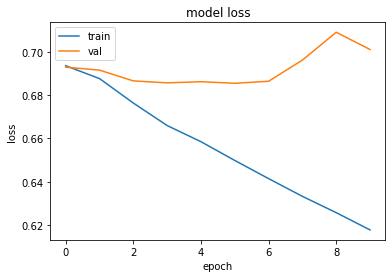

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate({'old_code': test_old_codeX, 'new_code': test_new_codeX, 'edit_code': test_editX, 'comment':test_commentX}, {'out':testY})
print("test loss, test acc:", results)

Evaluate on test data
454/454 [==============================] - 6s 14ms/step - loss: 0.6945 - accuracy: 0.5075
test loss, test acc: [0.6945074796676636, 0.5075069069862366]
